In [ ]:
from nbdev import *
%nbdev_default_export source_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.source_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Source Data management
> Extract data for a source

### Overview

Given a point source, the class `SourceData` manages all data-oriented operations, providing all that is necessary to create a set of cells. It depends on the modules

* `config` 
    This must set up the paths to the data created by `data_man`, and define paths for the effective area and weight files

* effective_area
* weights

It implements `binned_exposure`

In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
import healpy
import pickle
from pathlib import Path

from wtlike.config import *
from wtlike.data_man import *
from wtlike.effective_area import *
from wtlike.weights import *

In [ ]:
%nbdev_hide
# check the weekly files
config = Config(data_folder='/home/burnett/weekly', verbose=2)
if config.valid:
    ff = get_data_files(config)
    source = PointSource('Geminga')
    print(source)

Weekly folder "/home/burnett/weekly" contains 663 weeks, from 9 to 672
Most recent data to UTC 2021-04-22 00:50
Source "Geminga" at: (l,b)=(195.134,4.266)


In [ ]:
%nbdev_export
def _exposure(config,  livetime, pcosine):
    """return exposure calculated for each pair in livetime and cosines arrays

    uses effective area
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effectivee area function from
    ea = EffectiveArea(file_path=config.files.aeff)

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def _calculate_exposure_for_source(config, source, week):
    """
    Calcualate the exposure for the source during the given week
    """
    df = week['sc_data']
    
    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame( 
        dict(
            start=df.start[mask], 
            stop=df.stop[mask], 
            exp=_exposure(config, livetime, pcosines[mask]),
            cos_theta=pcosines[mask],
        ))




### Check exposure with last data file

In [ ]:
%nbdev_hide
if config.valid:
    filename=ff[-1]
    week = pickle.load( open(filename,'rb') )
    e_df = _calculate_exposure_for_source(config, source, week); 
    print(e_df.head())

	Found 17,058 S/C entries:  4,581 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 4 bins/decade
       start      stop       exp  cos_theta
78  59319.06  59319.06  77578.25       0.59
79  59319.06  59319.06  77549.61       0.59
80  59319.06  59319.06  77399.73       0.59
81  59319.06  59319.06  77545.79       0.59
82  59319.06  59319.06  77544.11       0.59


In [ ]:
%nbdev_export

def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - week : dict with 
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone]

    # distance from center for all accepted photons
    ll,bb = healpy.pix2ang(config.nside, dfc.nest_index,  nest=True, lonlat=True)
    cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
    t2 = np.degrees(np.array(np.sqrt((1.-np.dot(center, cart(ll,bb)))*2), np.float32))
    in_cone = t2<config.radius

    if config.verbose>2:
        print(f'\tGeometric cone cut: select {sum(in_cone)}')
    # assume all in the GTI (should check)

    # times: convert to float, add tstart, convert to MJD
    time = MJD(np.array(dfc.time, float)+tstart)

    # assemble the DataFrame, remove those outside the radius
    out_df = pd.DataFrame(np.rec.fromarrays(
        [np.array(dfc.band), time, dfc.nest_index, t2],
        names='band time pixel radius'.split()))[in_cone]

    # make sure times are monotonic by sorting (needed for most weeks after March 2018)
    out_df = out_df.sort_values(by='time')
    
    return out_df

### test photon data 

In [ ]:
%nbdev_hide
if config.valid:
    week = pickle.load(open(ff[0],'rb')); 
    tstart = week['tstart']
    print(f'TSTART: MET {tstart}, UTC {UTC(MJD(tstart))}')
    p_df = _get_photons_near_source(config, source, week )
    print(p_df.head())

TSTART: MET 239557417.0, UTC 2008-08-04 15:44
   band      time    pixel  radius
1     6  54682.66  6738278    0.70
2     3  54682.66  6761152    2.50
4     4  54682.66  6739138    0.29
5     1  54682.66  6714890    3.28
6     0  54682.66  6734033    5.02


In [ ]:
%nbdev_export

def get_default_bins(config, exposure):
    """set up default bins from exposure; and config.mjd_range if set.
    
    adjust stop to come out even,    round to whole day
    """

    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])
    if config.mjd_range is None:
        config.mjd_range = (start,stop)

    step = config.time_interval
    nbins = int(round((stop-start)/step))
    tb =time_bins = np.linspace(start, stop, nbins+1)
    if config.verbose>0:
        a,b = time_bins[0], time_bins[-1]
        print(f'Time bins: {nbins} intervals of {step} days, '\
              f'from MJD {a:.1f}({UTC(a)[:10]}) to {b:.1f}({UTC(b)[:10]}))')
    return time_bins        

def _load_from_weekly_data(config, source):
    """
    Generate combinded DataFrames from a list of pickled files
    Either weekly or monthly
    """
    
    # check weights
    weight_file =  check_weights(config,  source)
    assert weight_file is not None
    
    data_folder = Path(config.data_folder)
    data_files = sorted(list(data_folder.glob('*.pkl')))
    iname = data_folder.name
    
    if config.verbose>1:
        print(f"Assembling photon data and exposure for source {source.name} from"\
              f' folder "{data_folder}", with {len(data_files)} files,'\
              f' last={data_files[-1].name}')

    verbose, config.verbose=config.verbose, 0
    # list of data framees
    pp = []
    ee = []
    for f in data_files:
        print('.', end='')
        with open(f, 'rb') as inp:
            week = pickle.load(inp)
        pp.append(_get_photons_near_source(config, source, week ))
        ee.append(_calculate_exposure_for_source(config, source, week ))
    print('');    
    config.verbose=verbose
    # concatenate the two lists of DataFrames
    p_df = pd.concat(pp, ignore_index=True)
    e_df = pd.concat(ee, ignore_index=True)

    if config.verbose>1:
        times = p_df.time.values
        print(f'Loaded {len(p_df):,} photons from {UTC(times[0])} to  {UTC(times[-1])} ')
        print(f'Calculated {len(e_df):,} exposure entries')
        
    # add weights to photon data
    add_weights(config, p_df, source)
        
    return p_df, e_df

class SourceData(object):
    """ Load the photon data near the source and associated exposure. 
    
    Either from:
      1. `config.data_folder`, the Path to folder with list of pickle files with weekly or monthly data
      2. the cache, with key `{source.name}_data`
    
    * `config` : basic configuration: expect `config.data_folder` to be set
    * `source` : PointSource object
    * `clear` : if set, overwrite the cached results
    """
    
    def __init__(self, config, source, clear=False):
        """ 

        """
        verbose = config.verbose
        self.config = config
        self.source = source
        dname =  config.data_folder.name if config.data_folder is not None else ''
        key = f'{source.name}_{dname}_data'
        source.data_key = key
        
        if config.data_folder is None and key not in config.cache:
            raise Exception(f'Data for {source.name} is not cached, and config.data_folder is not set')
        
        self.p_df, self.e_df = config.cache(key, 
                                    _load_from_weekly_data, config, source, 
                                    overwrite=clear,
                                    description=f'photons and exposure for {source.name}')
    def __repr__(self):
        time = self.p_df.time.values
        r = f'{self.__class__.__name__}: Source {self.source.name} with:'\
            f'\n\t data:     {len(self.p_df):9,} photons from   {UTC(time[0])[:10]} to {UTC(time[-1])[:10]}'\
            f'\n\t exposure: {len(self.e_df):9,} intervals from {UTC(self.e_df.iloc[0].start)[:10]}'\
            f' to {UTC(self.e_df.iloc[-1].stop)[:10]}'
        return r
    
    def binned_exposure(self, time_bins=None):
        """Bin the exposure
        
        - time_bins: list of edges. if None, construct from exposure time limits and config.time_iterval 
        
        returns a tuple with:
        
        - bexp: array of exposure integrated over each time bin, normalized to total
        - time_bins

        """
        config = self.config

        # get exposure calculation
        exp   = self.e_df.exp.values
        estart= self.e_df.start.values
        estop = self.e_df.stop.values

        # determine bins, using config.time_interval, range of times
            # default bins depends on exposure
        if time_bins is None:
            time_bins = get_default_bins(config, self.e_df)

        #use cumulative exposure to integrate over larger periods
        cumexp = np.concatenate(([0],np.cumsum(exp)) )

        # get index into tstop array of the bin edges
        edge_index = np.searchsorted(estop, time_bins)
        # return the exposure integrated over the intervals
        cum = cumexp[edge_index]

        bexp = np.diff(cum)/(cum[-1]-cum[0]) * (len(time_bins)-1) 
        if config.verbose>1:
            print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
        return bexp, time_bins
    
    def binned_cos_theta(self, time_bins=None):
        """ Calculate average cosine of angle with respect to bore axis, per time bin
        """
        if time_bins is None:
            time_bins = get_default_bins(self.config, self.e_df)
        df = self.e_df.copy()
        estop =df.stop.values
        df.loc[:,'tbin'] =np.digitize(estop, time_bins)
        ct = df.groupby('tbin').mean()['cos_theta']
        return ct, time_bins
    
    def weight_histogram(self, nbins=1000, key=''):
        """ return a weight distribution
        """
        def doit(nbins):
            return np.histogram(self.p_df.weight.values, np.linspace(0,1,nbins+1))[0]

        key = f'{self.source.name}_weight_hist' if key=='' else key
        description = f'Weight histogram for {self.source.name}' if self.config.verbose>0 else ''
        return self.config.cache(key, doit, nbins, description=description)
        
    def plot(self):
        import matplotlib.pyplot as plt
        fig, (ax1,ax2, ax3,ax4) = plt.subplots(1,4, figsize=(15,4))
        ax1.hist(self.p_df.time.values, 500, histtype='step');
        ax1.set(xlabel='Time (MJD)')
        ax2.hist(self.p_df.radius.values, 500, histtype='step');
        ax2.set(xlabel='Radius (deg)');
        
        ax3.hist(self.p_df.band, 32, histtype='step', log=True);
        ax3.set(xlabel='Band index')
        ax4.hist(self.p_df.weight, 100, histtype='step')
        ax4.set(xlabel='weight');

In [ ]:
#hide
show_doc(SourceData)
show_doc(SourceData.binned_exposure)

<h2 id="SourceData" class="doc_header"><code>class</code> <code>SourceData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SourceData</code>(**`config`**, **`source`**, **`clear`**=*`False`*)

Load the photon data near the source and associated exposure. 

Either from:
  1. `config.data_folder`, the Path to folder with list of pickle files with weekly or monthly data
  2. the cache, with key `{source.name}_data`

* [`config`](wtlike/config) : basic configuration: expect `config.data_folder` to be set
* `source` : PointSource object
* `clear` : if set, overwrite the cached results

<h4 id="SourceData.binned_exposure" class="doc_header"><code>SourceData.binned_exposure</code><a href="__main__.py#L106" class="source_link" style="float:right">[source]</a></h4>

> <code>SourceData.binned_exposure</code>(**`time_bins`**=*`None`*)

Bin the exposure

- time_bins: list of edges. if None, construct from exposure time limits and config.time_iterval 

returns a tuple with:

- bexp: array of exposure integrated over each time bin, normalized to total
- time_bins

## Test extracting full dataset

photons and exposure for Geminga: Saving to cache with key "Geminga_weekly_data"
Assembling photon data and exposure for source Geminga from folder "/home/burnett/weekly", with 663 files, last=week_672.pkl
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Loaded 2,381,241 photons from 2008-08-04 15:46 to  2021-04-22 00:36 
Calculated 3,106,496 exposure entries
Load weights from file 

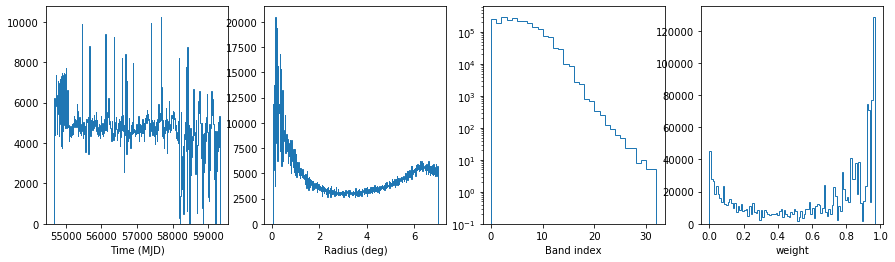

In [ ]:
%nbdev_hide
if config.valid:
    sd = SourceData(config, source, clear=False); 
    print(sd)
    sd.plot()

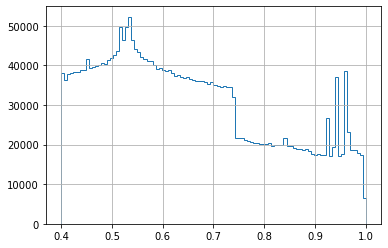

In [ ]:
sd.e_df.cos_theta.hist(bins=100);

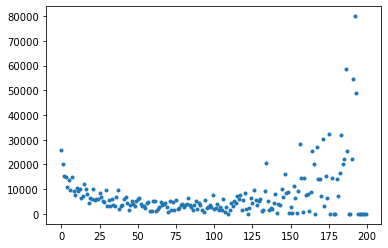

In [ ]:
plt.plot(sd.weight_histogram(200,key=None), '.')

In [ ]:
self = sd
time_bins = None
if time_bins is None:
    time_bins = get_default_bins(config, self.e_df)

Time bins: 4643 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59326.0(2021-04-22))


In [ ]:
df = self.e_df.copy()
estop =df.stop.values
df.loc[:,'tbin'] = np.digitize(estop, time_bins)
ct = df.groupby('tbin').mean()['cos_theta']
ct, bins = sd.binned_cos_theta()
print(len(ct), len(time_bins))
ct

Time bins: 4643 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59326.0(2021-04-22))
4519 4644


tbin
0       0.68
1       0.68
2       0.67
3       0.68
4       0.68
        ... 
4640    0.77
4641    0.75
4642    0.67
4643    0.67
4644    0.65
Name: cos_theta, Length: 4519, dtype: float32

In [ ]:
ctx = df.groupby('tbin').agg({'cos_theta': ['count','mean', 'min', 'max']})
ctx

cos_theta                  
         count  mean   min   max
tbin                            
0          336  0.68  0.40  0.82
1          793  0.68  0.40  0.84
2          778  0.67  0.40  0.87
3          740  0.68  0.40  0.89
4          876  0.68  0.40  0.91
...        ...   ...   ...   ...
4640       569  0.77  0.51  0.96
4641       673  0.75  0.40  0.96
4642       730  0.67  0.40  0.93
4643       744  0.67  0.40  0.93
4644        19  0.65  0.41  0.92

[4519 rows x 4 columns]

Time bins: 4643 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59326.0(2021-04-22))
4519 4644


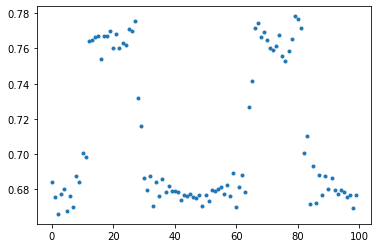

In [ ]:
ct, bins = sd.binned_cos_theta()
print(len(ct), len(bins))
plt.plot(ct.index[:100], ct[:100],'.');

In [ ]:
%nbdev_hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_source_data.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Mon Apr 26 16:11:27 PDT 2021
